In [ ]:
#pip install nltk,seaborn,scikit-learn,tf-keras,tensorflow==2.7.0,tqdm,datasets
#!pip install transformers==4.18.0

In [139]:
#import packages

In [1]:
import numpy as np
import pandas as pd
import nltk
import string as s
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
#nltk.download('popular')
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
warnings.filterwarnings("ignore")

In [2]:
#This file consists of 7600 testing samples of news articles that contain 3 columns. The first column is Class Id, the second column is Title and the third column is Description. The class ids are numbered 1-4 where 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech.
train_data = pd.read_csv('C:\\Users\\jina.ghosh\\OneDrive - Fractal Analytics Pvt. Ltd\\Documents\\evoluation\\topic_classification\\archive\\train.csv', header=0,names=['ID','Title','Desc'])
test_data = pd.read_csv('C:\\Users\\jina.ghosh\\OneDrive - Fractal Analytics Pvt. Ltd\\Documents\\evoluation\\topic_classification\\archive\\test.csv', header=0,names=['ID','Title','Desc'])

In [ ]:
#taking 1000 samples for each class for faster training

In [3]:
train_data1=train_data[train_data['ID']==1][:1000]
train_data2=train_data[train_data['ID']==2][:1000]
train_data3=train_data[train_data['ID']==3][:1000]
train_data4=train_data[train_data['ID']==4][:1000]
train_data5=pd.concat([train_data1,train_data2,train_data3,train_data4])

In [4]:
train_data=train_data5.copy()

In [5]:
#feature engineering

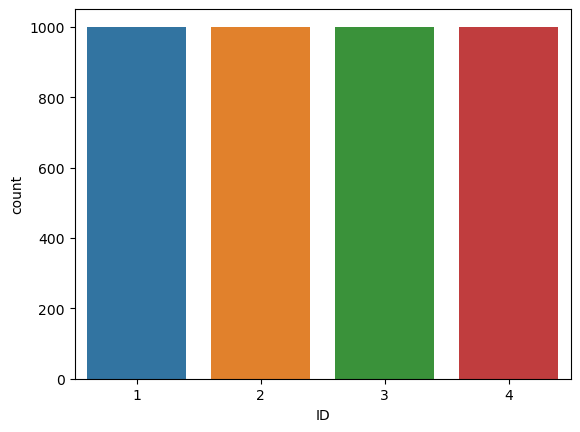

In [6]:
#to check category wise distribution
sns.countplot(x = 'ID', data = train_data)
plt.show()

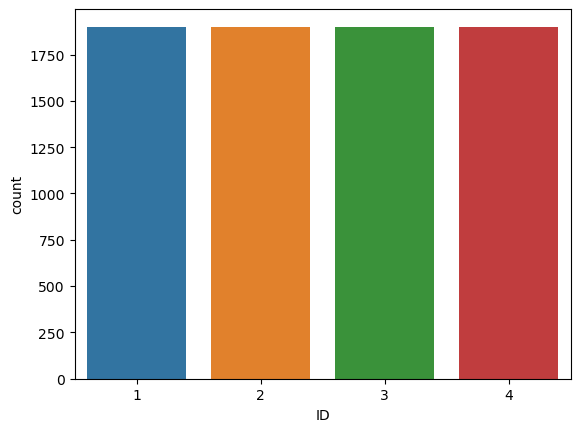

In [7]:
sns.countplot(x = 'ID', data = test_data)
plt.show()

In [8]:
#converting Title and Description as single column 
train_data['combined_text'] = train_data[['Title','Desc']].apply(lambda x: ' '.join(x[x.notnull()]), axis = 1)
test_data['combined_text'] = test_data[['Title','Desc']].apply(lambda x: ' '.join(x[x.notnull()]), axis = 1)


In [9]:
#As model will understand label encoding from 0 to 3
train_data['ID'].replace({4:0}, inplace = True)
test_data['ID'].replace({4:0}, inplace = True)

In [10]:
def preprocess_text(message):

    #stopwords
    stpwrd = nltk.corpus.stopwords.words('english')
    # 1. Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    #removing the special char and working only with text values
    message = re.sub('[^ A-Za-z0-9.:;%@&#/\'\",><\-]', "", message )
    #removing the stopwords
    message = re.sub(r'http\S+','', message)
    message = ' '.join([word for word in message.split() if word not in stpwrd and len(word)>1 ])
    #lemmatizing the text
    message =  " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(message) if w not in string.punctuation])
    message=message.lower()
    return message

In [11]:
train_data['processed_text'] = train_data['combined_text'].map(lambda s:preprocess_text(s)) 
test_data['processed_text'] = test_data['combined_text'].map(lambda s:preprocess_text(s)) 

In [12]:
#splitting the data

In [13]:
X = train_data[['Title','Desc','processed_text']]
y= train_data['ID']
# split the cicd data into train and test 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .20,stratify=y, random_state = 42)
print('Training data size: {}'.format(len(X_train)))
print('Validation data size: {}'.format(len(X_val)))

print(f"{len(X_train)} training examples\n{len(X_val)} validation examples")

Training data size: 3200
Validation data size: 800
3200 training examples
800 validation examples


In [14]:
x_test = test_data[['Title','Desc','processed_text']]
y_test = test_data['ID']
print(f"{len(x_test)} testing examples")

7600 testing examples


In [15]:
#The DistilBertTokenizer generates input_ids and attention_mask as outputs. This is what is required by a DistilBert model as its inputs.
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased",  
                                                add_special_tokens=True,
                                                pad_to_max_length=True)
train_encodings = tokenizer(X_train['processed_text'].to_list(), truncation=True, padding=True)
val_encodings = tokenizer(X_val['processed_text'].to_list(), truncation=True, padding=True)
#test_encodings = tokenizer(x_test['processed_text'].to_list(), truncation=True, padding=True)

In [16]:
val_encodings

{'input_ids': [[101, 1996, 3296, 2566, 20240, 2094, 23879, 6457, 1996, 3296, 2566, 20240, 2094, 23879, 6457, 2746, 19939, 2121, 2360, 2071, 12890, 2204, 2066, 11829, 9039, 2075, 2217, 3332, 3048, 2482, 14231, 2566, 20240, 2094, 3011, 17643, 16750, 2071, 2404, 24820, 2265, 10434, 2733, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 7738, 4978, 5712, 3097, 3757, 9706, 9706, 2312, 7738, 2718, 2430, 4524, 16102, 9317, 2485, 4680, 2415, 3145, 2120, 7215, 2576, 3412, 8388, 3003, 3133, 2345, 2154, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.to_list()
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val.to_list()
))

In [18]:
val_dataset

<TensorSliceDataset shapes: ({input_ids: (140,), attention_mask: (140,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [19]:
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5, # total number of training epochs
    learning_rate=2e-5, 
    per_device_train_batch_size=16,  # batch size per device during training   
    optim="adamw_torch",
    eval_steps=3,
    weight_decay=0.01, # strength of weight decay
    save_strategy = 'epoch',
    report_to="none", # Stops transformers from trying to connect to weights and biases site
    logging_dir='./logs',            # directory for storing logs
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

trainer = TFTrainer(
    model=trainer_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
)

In [20]:
%time trainer.train()

CPU times: total: 4h 27min 18s
Wall time: 1h 34min 23s


In [21]:
trainer.evaluate()

{'eval_loss': 0.32226215362548827}

In [22]:
#storing trained tokenizer,model

In [23]:
save_directory = "/saved_models_sample" # change this to your preferred location

trainer_model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

In [24]:
#predict on test data

In [29]:
# Initialize an empty list to store the encoded inputs
preds_flat = []

# Iterate over each processed text in test_data
for processed_text in tqdm(test_data['processed_text'][:7600]):
    # Encode the processed text
    encoded_input = loaded_tokenizer.encode(
        processed_text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    output = loaded_model(encoded_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    # Append the encoded input to the list
    preds_flat.append(prediction_value)



100%|█████████████████████████████████████████████████████████████████████████████████████████| 7600/7600 [2:44:43<00:00,  1.30s/it]


In [47]:
h= pd.DataFrame({'predicted_id': preds_flat})
test_data['predicted_id']=h['predicted_id']

In [50]:
#converting label encoded id into original id
test_data['predicted_id'].replace({0:4}, inplace = True)
test_data['ID'].replace({0:4}, inplace = True)

In [51]:
#dropping rest of the column
test_data.drop(['combined_text','processed_text'],axis=1)

,ID,Title,Desc,predicted_id
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,3
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",4
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,4
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,4
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,4
...,...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,1
7596,2,Void is filled with Clement,With the supply of attractive pitching options...,2
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,2
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,4


In [52]:
test_data.to_csv('test_data_submission.csv',index=False)

In [55]:
#checking the accuracy

In [58]:
from sklearn.metrics import accuracy_score

test_labels = test_data['ID'][:7600]  # Assuming this contains true labels

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_data['predicted_id'])

print("Accuracy:", accuracy)

Accuracy: 0.8984210526315789


In [59]:
precision, recall, fscore, support = score(test_data['ID'][:7600], test_data['predicted_id'])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93072626 0.95865633 0.86121571 0.84623016]
recall: [0.87684211 0.97631579 0.84263158 0.89789474]
fscore: [0.90298103 0.96740548 0.85182229 0.87129724]
support: [1900 1900 1900 1900]
